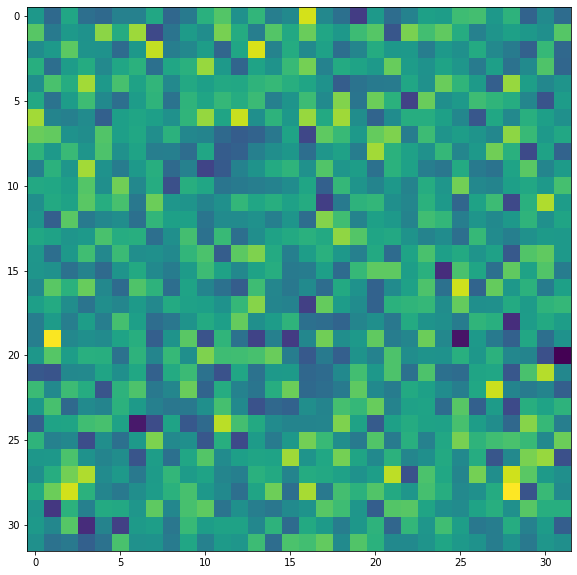

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time
from PIL import Image, ImageOps
from scipy.linalg import hadamard
from os.path import join

rc = "racecar.jpg"
br = "5.png"
path = "rollingball"

#raw_img = cv2.imread(rc)
raw_img = cv2.imread(br)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
#gray_img = cv2.resize(gray_img, (sz,sz)) 

# Convert to number array
objs = np.array(gray_img)
    
imsize = 32**2

# Make measurements
#obj_br = np.reshape(jointimg, (32,96)) #Reshape to a vector to make maths easier
random = np.random.randint(0,2, size=(1024, 1024))
random = [[-1 if (x < 1) else x for x in y] for y in random]
random = np.array(random)

I = np.identity(imsize)
H = hadamard(imsize)
m = np.zeros((imsize,1))

PatternSet  =  random; # Chose H or I here.

length = 50
# Measure for each pattern
for i in range(0,imsize):                                  # for each pixel value
    a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
    obj = objs[:,a:a+32]                                   # now obj changes for each measurement
    #print(a)
    
    samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
    samplingPattern = np.reshape(samplingVector,(32,32))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
    #plt.imshow(obj)                                       # shows the rasterscan in action, each coord being moved thru
    #plt.show()
    #time.sleep(0.005)
    m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
    #print(m)

# Reconstruct Image
recon = np.matmul(PatternSet,m)                    
recon = np.reshape(recon, (32,32))
plt.rcParams['figure.figsize'] = [18,10] # set the image size
fig = plt.imshow(recon)

Above is the processing of a racecar image with dimensions 96x32 pixels, because the quality is so poor it is hard to make out any details. Below is the same processing but now with the same image at a quality of 192x64 pixels, taking sections of size 64x64:

(4096, 4096)
[ 999 2444 3912 ... 1928 1479 2167]


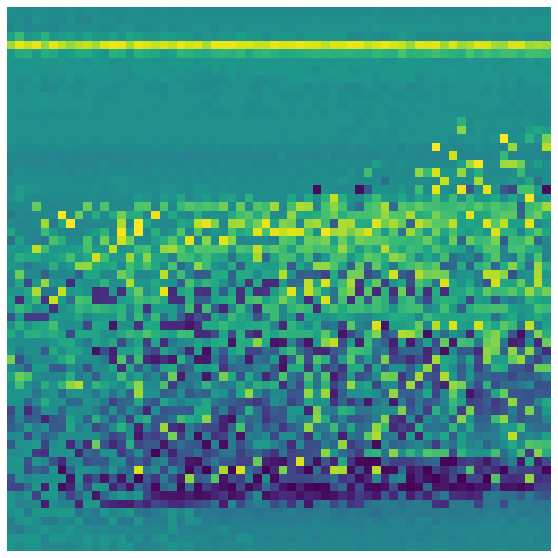

In [82]:
rc64 = "racecar64.jpg"
#rc64 = "3.png"
raw_img = cv2.imread(rc64)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
gray_img = cv2.resize(gray_img, (192,64)) 

# Convert to number array
objs = np.array(gray_img)
    
imsize = 64**2

# Make measurements
I = np.identity(imsize)
H = hadamard(imsize)

# this bit for democratised pattern
random4dem = np.random.rand(4096,4096)
rand_med = np.median(random4dem)
random4dem = [[1 if (x >= rand_med) else -1 for x in y] for y in random4dem]
random4dem = np.array(random4dem)
print(random4dem.shape)
dem = np.multiply(H,random4dem)         # multiplying hadamard matrix with random matrix

m = np.zeros((imsize,1))


# this bit for random rasterscan
rand_num = np.random.rand(imsize)
indexes = np.argsort(rand_num)
print(indexes)

J = np.zeros((imsize,imsize))
for i,ind in enumerate(indexes):
    J[:,i] = I[:,ind]             # J is a row shuffled identity matrix

#random = np.random.randint(0,2, size=(4096, 4096))                  # uncomment this bit for random matrix
#random = [[-1 if (x < 1) else x for x in y] for y in random]
#random = np.array(random)

PatternSet  =  J; # Choose H or I here, or random, or J, or dem

length = 50                      # Image appears more smeared the higher this number is - object is 'moving' faster - max is 128
allobjs = []
image = np.zeros((64,64))
# Measure for each pattern
for i in range(0,imsize):                                  # for each pixel value
    a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
    obj = objs[:,a:a+64]                                   # now obj changes for each measurement - simulates moving object
    allobjs.append(obj)
    #print(a)
    
    samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
    samplingPattern = np.reshape(samplingVector,(64,64))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
    #plt.imshow(obj)                                       # shows the rasterscan in action, each coord being moved thru
    #plt.show()
    #time.sleep(0.005)
    m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
    image = samplingPattern * obj + image          # Image is the pattern multiplied by value + image for each index
    #print(m)

# Reconstruct Image
recon = np.matmul(PatternSet,m)                    # recon is image formed by multiplying pattern used and signal
recon = np.reshape(recon, (64,64))
plt.rcParams['figure.figsize'] = [18,10] # set the image size
fig = plt.imshow(image)                  # can have image or recon for the plotted image
#fig = plt.imshow(recon)
plt.axis('off')
#plt.savefig('randrast64rc50.png')

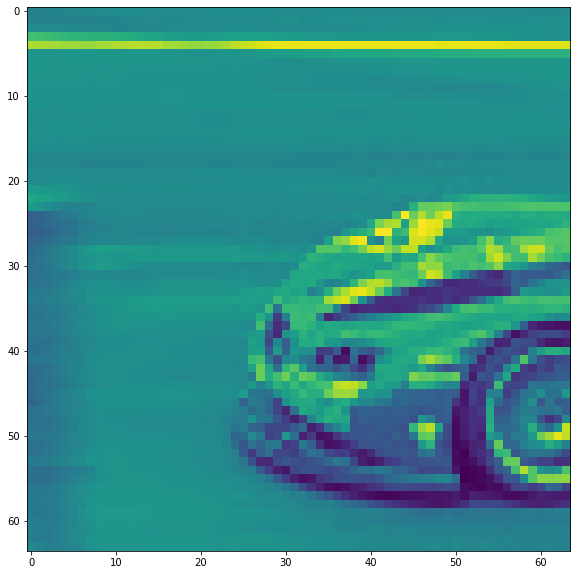

In [3]:
plt.imshow(allobjs[0]) # just seeing what the last obj looks like 
plt.show()

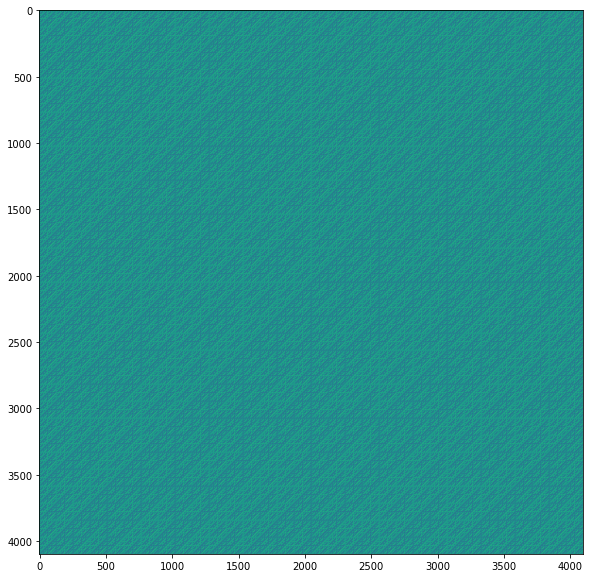

In [4]:
sz = 64    
imsize = sz**2

H = hadamard(imsize)
plt.imshow(H)


# Ordering the hadamard in terms of frequency

In [5]:
patterns = []           # creating empty arrays to bring the patterns and freqs out the loop
freqs = []

for i in range(0,imsize):
    pattern = np.reshape(H[:,i],(sz,sz))
    freq = (np.sum(np.abs(np.diff(pattern,axis=0))) + np.sum(np.abs(np.diff(pattern,axis=1))))/8
    patterns.append(pattern)
    freqs.append(freq)
    #plt.imshow(pattern)
    #plt.title(['Spatial Changes = ', str(freq)])
    #plt.show()

patterns = np.array(patterns)    # changing the lists to numpy arrays
freqs = np.array(freqs)
inds = freqs.argsort()           # sorting pattern matrices by the frequency number
sorted_h = patterns[inds]
sorted_freqs = sorted(freqs)        

Now checking the patterns did actually get sorted. Commented because it takes a while to run:

In [6]:
#for i,j in zip(sorted_h,sorted_freqs):
#    plt.imshow(i)
#    plt.title(['Spatial Changes = ', str(j)])
    #plt.show()

(64, 192)


(-0.5, 63.5, 63.5, -0.5)

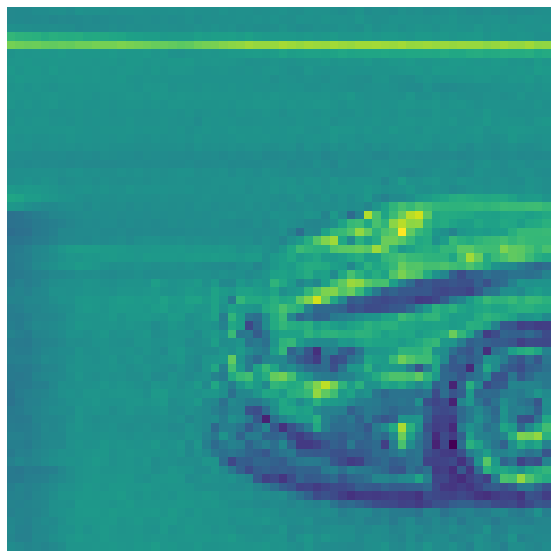

In [7]:
#rc64 = "3.png"                # can choose either car or ball
rc64 = "racecar64.jpg"
raw_img = cv2.imread(rc64)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
gray_img = cv2.resize(gray_img, (192,64)) 

# Convert to number array
objs = np.array(gray_img)
print(objs.shape)
    
imsize = 64**2

# Make measurements
m = np.zeros((imsize,1))

#PatternSet  =  H; # Chose H or I here.

length = 2                      # Image appears more smeared the higher this number is - object is 'moving' faster - max is 128

img = np.zeros((64,64))

allobjs = []
for i,j in zip(sorted_h,(range(0,imsize))):
    a = round(j*(length/imsize))
    obj = objs[:,a:a+64]
    #allobjs.append(obj)
    #samplingVector = i[j,:]
    #print(samplingVector)
    #samplingPattern = np.reshape(samplingVector,(64,64))
    m[j] = np.sum(i*obj)
    
    img = img + m[j]*i
    
plt.imshow(img)
plt.axis('off')
#plt.savefig('ordrdH64racecar100.png')

# Democratised Patterns

Now trying to reconstruct the image using democratised patterns - these are randomised Hadamard patterns. Going to produce them my multiplying a Hadamard matrix with a random matrix. Then find the median value (M) of the produced matrix and everything greater than M will be 1 and everything less than will be -1.

In [31]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time
from PIL import Image, ImageOps
from scipy.linalg import hadamard

In [48]:
H = hadamard(1024)
random = np.random.rand(1024,1024)
rand_med = np.median(random)
random = [[1 if (x >= rand_med) else -1 for x in y] for y in random]
random = np.array(random)
dem = np.multiply(H,random)         # multiplying hadamard matrix with random matrix
random.shape

(1024, 1024)

In [33]:
dem = np.multiply(H,random)         # multiplying hadamard matrix with random matrix
median = np.mean(dem)             # Finding median of dem
median

-0.000164031982421875

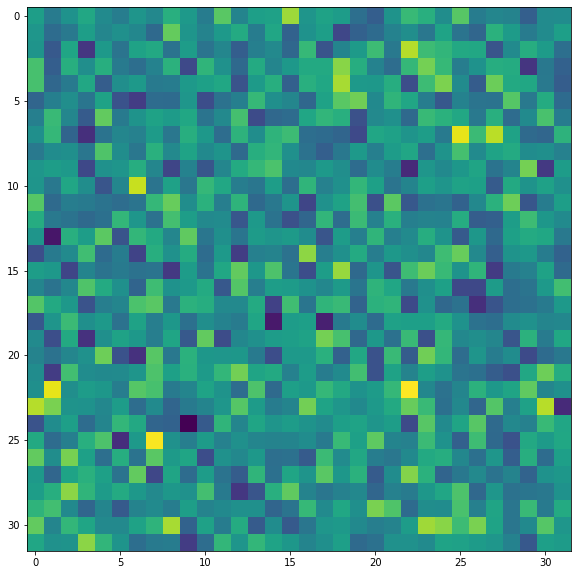

In [34]:
rc = "racecar.jpg"
br = "5.png"

raw_img = cv2.imread(rc)
#raw_img = cv2.imread(br)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
#gray_img = cv2.resize(gray_img, (sz,sz)) 

# Convert to number array
objs = np.array(gray_img)
    
imsize = 32**2
m = np.zeros((imsize,1))

PatternSet  = dem; # Chose H or I here.

length = 0
# Measure for each pattern
for i in range(0,imsize):                                  # for each pixel value
    a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
    obj = objs[:,a:a+32]                                   # now obj changes for each measurement
    #print(a)
    
    samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
    samplingPattern = np.reshape(samplingVector,(32,32))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
    m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
    #print(m)

# Reconstruct Image
recon = np.matmul(PatternSet,m)                    
recon = np.reshape(recon, (32,32))
plt.rcParams['figure.figsize'] = [18,10] # set the image size
fig = plt.imshow(recon)

In [58]:
random64 = np.random.rand(64,64)
rand_med64 = np.median(random64)
random64 = [[1 if (x >= rand_med64) else -1 for x in y] for y in random64]

sz = 64    
imsize = sz**2
H = hadamard(imsize)
patterns = []           # creating empty arrays to bring the patterns and freqs out the loop
freqs = []

for i in range(0,imsize):
    pattern = np.reshape(H[:,i],(sz,sz))
    freq = (np.sum(np.abs(np.diff(pattern,axis=0))) + np.sum(np.abs(np.diff(pattern,axis=1))))/8
    patterns.append(pattern)
    freqs.append(freq)

patterns = np.array(patterns)    # changing the lists to numpy arrays
freqs = np.array(freqs)
inds = freqs.argsort()           # sorting pattern matrices by the frequency number
sorted_h = patterns[inds]
sorted_freqs = sorted(freqs) 

sorted_dems = [np.multiply(i, random64) for i in sorted_h]
medians = [np.median(i) for i in sorted_dems]

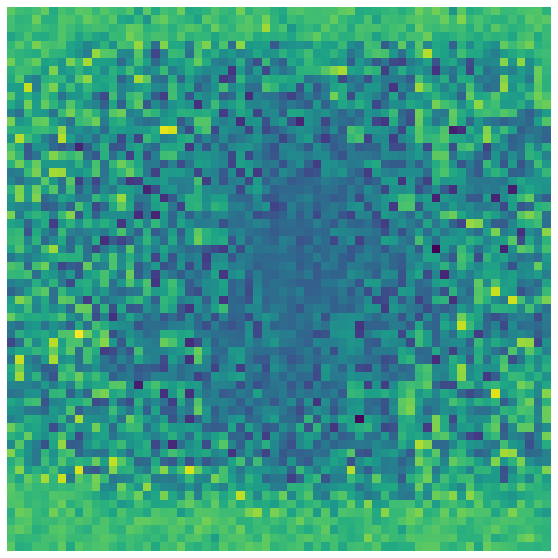

In [72]:
rc64 = "3.png"                # can choose either car or ball
#rc64 = "racecar64.jpg"
raw_img = cv2.imread(rc64)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
gray_img = cv2.resize(gray_img, (192,64)) 

# Convert to number array
objs = np.array(gray_img)
    
imsize = 64**2

# Make measurements
m = np.zeros((imsize,1))
length = 50                 # Image appears more smeared the higher this number is - object is 'moving' faster - max is 128
img = np.zeros((64,64))

allobjs = []
for i,j in zip(sorted_dems,(range(0,imsize))):
    a = round(j*(length/imsize))
    obj = objs[:,a:a+64]
    m[j] = np.sum(i*obj)
    
    img = img + m[j]*i
    
plt.imshow(img)
plt.axis('off')
#plt.savefig('ordrddem64ball50.png')

In [12]:
random.shape

(1024, 1024)